In [21]:
# --- Celda 1: Configuración del Entorno ---

import pandas as pd
import numpy as np
from datetime import datetime, timedelta
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score
import joblib
import warnings

warnings.filterwarnings('ignore')

print("Librerías cargadas exitosamente.")

Librerías cargadas exitosamente.


In [8]:
# --- Celda 2 (Versión Final y Controlada): Generación del Dataset con Objetivo Fijo ---

file_name = 'ventas_almacen_v2.csv'
target_transactions = 14000 # Objetivo de transacciones

if not os.path.exists(file_name):
    print(f"Generando dataset con un objetivo de ~{target_transactions} transacciones...")

    # Catálogo de Productos y Perfiles de Clientes (sin cambios)
    products = {
        'Licores': {'Ron Añejo': 15, 'Vino Tinto': 10, 'Caja de Cerveza': 20, 'Vodka': 18, 'Caja de Cigarros': 5},
        'Snacks': {'Queso Amarillo (kg)': 12, 'Jamón Serrano (100g)': 8, 'Papas Fritas': 3, 'Aceitunas': 4, 'Mix de Maní': 4},
        'Bebidas/Panadería': {'Refresco 2L': 3, 'Agua Mineral 5L': 4, 'Hielo (bolsa)': 2, 'Pan Campesino': 2},
        'Cuidado Personal': {'Crema Dental': 3, 'Jabón de Baño': 2, 'Afeitadoras': 4, 'Champú': 5},
        'Limpieza': {'Cloro (1L)': 2, 'Lavaplatos': 3, 'Servilletas': 1, 'Bolsas de Basura': 3}
    }
    all_products = [{'name': name, 'price': price, 'category': cat} for cat, items in products.items() for name, price in items.items()]
    product_df = pd.DataFrame(all_products)

    customer_profiles = {
        'anfitrion': {'id_range': range(1, 61), 'days': [4, 5], 'basket_size': (3, 7)},
        'diario': {'id_range': range(61, 201), 'days': [0, 1, 2, 3], 'basket_size': (1, 4)},
        'especifico': {'id_range': range(201, 301), 'days': random.sample(range(7), 3), 'basket_size': (1, 2)}
    }

    # Nueva Lógica de Generación Controlada
    transactions = []
    start_date = datetime(2023, 7, 1)
    
    # Probabilidades de que un tipo de cliente realice la siguiente compra
    profile_weights = [0.3, 0.6, 0.1] # 30% anfitrion, 60% diario, 10% especifico

    while len(transactions) < target_transactions:
        # 1. Elige un tipo de perfil de cliente basado en su peso
        profile_name = random.choices(list(customer_profiles.keys()), weights=profile_weights, k=1)[0]
        profile_data = customer_profiles[profile_name]
        
        # 2. Elige un cliente aleatorio de ese perfil
        customer_id = random.choice(profile_data['id_range'])
        
        # 3. Genera una fecha de compra aleatoria que coincida con los días de compra del perfil
        day_offset = random.randint(0, 729)
        purchase_date = start_date + timedelta(days=day_offset)
        # Asegurarse de que el día de la semana sea correcto para el perfil
        while purchase_date.weekday() not in profile_data['days']:
            day_offset = random.randint(0, 729)
            purchase_date = start_date + timedelta(days=day_offset)
            
        # 4. Genera la cesta de la compra
        num_items = random.randint(profile_data['basket_size'][0], profile_data['basket_size'][1])
        basket = product_df.sample(num_items, replace=True)
        
        for _, item in basket.iterrows():
            transactions.append({
                'CustomerID': customer_id, 'Date': purchase_date, 'ProductName': item['name'],
                'Category': item['category'], 'Quantity': 1, 'UnitPrice': item['price']
            })

    df_ventas = pd.DataFrame(transactions)
    df_ventas['TotalPrice'] = df_ventas['Quantity'] * df_ventas['UnitPrice']
    
    # Asegurarse de que los datos estén ordenados por fecha
    df_ventas = df_ventas.sort_values(by='Date')
    
    df_ventas.to_csv(file_name, index=False)
    print(f"Dataset guardado. Se generaron {len(df_ventas)} transacciones.")

else:
    print(f"El archivo '{file_name}' ya existe. No se generará de nuevo para mantener la consistencia.")

Generando dataset con un objetivo de ~14000 transacciones...
Dataset guardado. Se generaron 14002 transacciones.


In [22]:
# --- Celda 3: Carga del Dataset ---

# Cargamos el archivo CSV validado
df = pd.read_csv('ventas_almacen_v2.csv')

# Aseguramos que la columna de fecha esté en el formato correcto
df['Date'] = pd.to_datetime(df['Date'])

print("Dataset 'ventas_almacen_v2.csv' cargado correctamente.")
print(f"El dataset contiene {df.shape[0]} transacciones.")
df.head()

Dataset 'ventas_almacen_v2.csv' cargado correctamente.
El dataset contiene 14002 transacciones.


,CustomerID,Date,ProductName,Category,Quantity,UnitPrice,TotalPrice
0,6,2023-07-01,Servilletas,Limpieza,1,1,1
1,6,2023-07-01,Vodka,Licores,1,18,18
2,6,2023-07-01,Jabón de Baño,Cuidado Personal,1,2,2
3,20,2023-07-01,Jamón Serrano (100g),Snacks,1,8,8
4,5,2023-07-01,Caja de Cigarros,Licores,1,5,5


In [23]:
# --- Celda 4: Ingeniería de Características (RFM y Adicionales) ---

# Establecemos una fecha de referencia para los cálculos (1 día después de la última venta)
snapshot_date = df['Date'].max() + timedelta(days=1)

# Calculamos RFM
customer_data = df.groupby('CustomerID').agg({
    'Date': lambda date: (snapshot_date - date.max()).days, # Recencia (R)
    'ProductName': 'count',                                # Frecuencia (F)
    'TotalPrice': 'sum'                                    # Monetario (M)
}).rename(columns={'Date': 'Recency', 'ProductName': 'Frequency', 'TotalPrice': 'Monetary'})

# Calculamos las características adicionales
additional_features = df.groupby('CustomerID').agg(
    ticket_promedio=('TotalPrice', 'mean'),
    dias_desde_primera_compra=('Date', lambda date: (snapshot_date - date.min()).days)
)

# Unimos todo en un único dataframe de características por cliente
features_df = customer_data.join(additional_features)

print("DataFrame de características creado exitosamente.")
features_df.head()

DataFrame de características creado exitosamente.


,Recency,Frequency,Monetary,ticket_promedio,dias_desde_primera_compra
CustomerID,,,,,
1,1,125,751,6.008000,723
2,9,101,635,6.287129,708
3,50,113,699,6.185841,673
4,106,56,375,6.696429,722
5,1,128,684,5.343750,729


In [24]:
# --- Celda 5: Definición de Target y Entrenamiento del Modelo ---

# 1. Definir el Target (y)
# Cliente de 'Alto Valor' = Top 25% en Frecuencia Y Gasto Monetario
freq_q3 = features_df['Frequency'].quantile(0.75)
monetary_q3 = features_df['Monetary'].quantile(0.75)
features_df['AltoValor'] = ((features_df['Frequency'] >= freq_q3) & (features_df['Monetary'] >= monetary_q3)).astype(int)

# 2. Separar Features (X) y Target (y)
X = features_df[['Recency', 'Frequency', 'Monetary', 'ticket_promedio', 'dias_desde_primera_compra']]
y = features_df['AltoValor']

# 3. Dividir los datos para entrenamiento y prueba
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)

# 4. Entrenar el Modelo de Clasificación
# Usamos RandomForest, que es potente y bueno para este tipo de datos
# class_weight='balanced' ayuda a que el modelo preste atención a la clase minoritaria (los clientes de alto valor)
model = RandomForestClassifier(n_estimators=100, random_state=42, class_weight='balanced')
model.fit(X_train, y_train)

print("Modelo RandomForestClassifier entrenado exitosamente.")
print(f"Se identificaron {y.sum()} clientes como 'Alto Valor'.")

Modelo RandomForestClassifier entrenado exitosamente.
Se identificaron 71 clientes como 'Alto Valor'.


Accuracy del modelo: 0.9833

Reporte de Clasificación:
                   precision    recall  f1-score   support

No Alto Valor (0)       0.98      1.00      0.99        46
   Alto Valor (1)       1.00      0.93      0.96        14

         accuracy                           0.98        60
        macro avg       0.99      0.96      0.98        60
     weighted avg       0.98      0.98      0.98        60



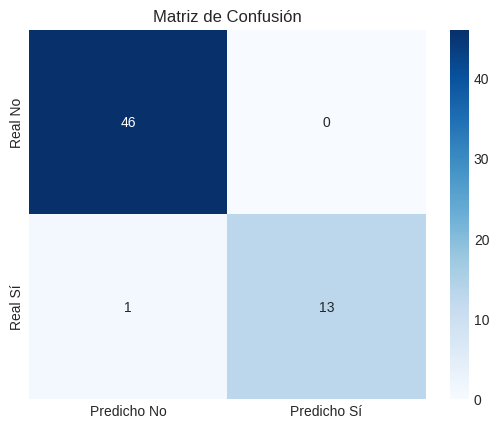

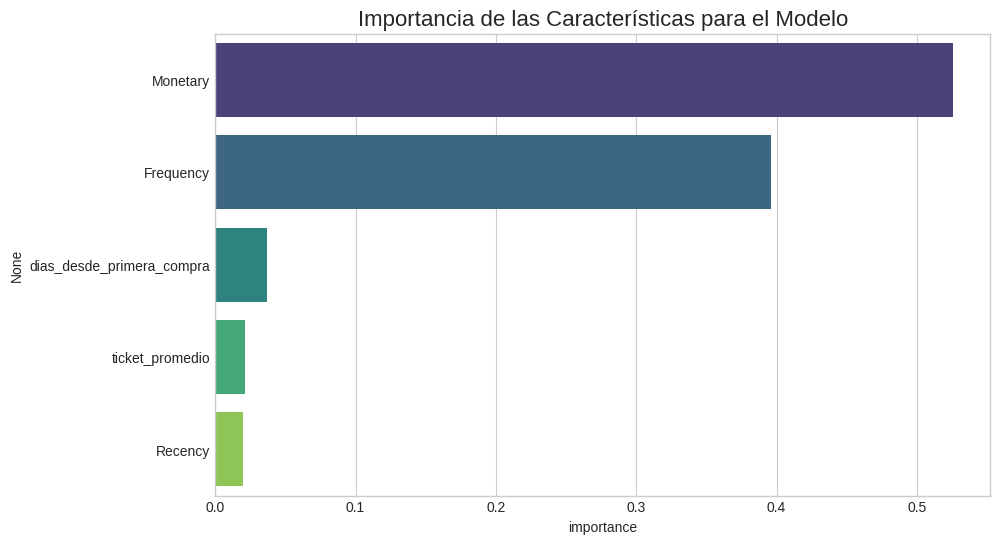

In [25]:
# --- Celda 6: Evaluación del Modelo ---
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score

# 1. Realizar predicciones en los datos de prueba
y_pred = model.predict(X_test)

# 2. Imprimir métricas clave
print(f"Accuracy del modelo: {accuracy_score(y_test, y_pred):.4f}\n")
print("Reporte de Clasificación:")
print(classification_report(y_test, y_pred, target_names=['No Alto Valor (0)', 'Alto Valor (1)']))

# 3. Matriz de Confusión (opcional pero útil)
conf_matrix = confusion_matrix(y_test, y_pred)
sns.heatmap(conf_matrix, annot=True, fmt='g', cmap='Blues',
            xticklabels=['Predicho No', 'Predicho Sí'],
            yticklabels=['Real No', 'Real Sí'])
plt.title('Matriz de Confusión')
plt.show()

# 4. Gráfico de Importancia de Características
feature_importances = pd.DataFrame(model.feature_importances_, index=X.columns, columns=['importance']).sort_values('importance', ascending=False)

plt.figure(figsize=(10, 6))
sns.barplot(x=feature_importances.importance, y=feature_importances.index, palette='viridis')
plt.title('Importancia de las Características para el Modelo', fontsize=16)
plt.show()

In [26]:
# --- Celda 7: Serialización (Guardado) del Modelo ---
import joblib

# Nombre del archivo donde se guardará el modelo
model_filename = 'VICtoria_model.pkl'

# Guardar el modelo
joblib.dump(model, model_filename)

print(f"¡Modelo guardado exitosamente como '{model_filename}'!")

¡Modelo guardado exitosamente como 'VICtoria_model.pkl'!
